In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer
from tqdm.auto import tqdm
import random

In [2]:
train_data = torchvision.datasets.CIFAR10(
    root="data", 
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None 
)

# Setup testing data
test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False, 
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
len(train_data[0])

2

In [5]:
#train_data[0] --> (tensor(image),label)

In [6]:
image,label=train_data[0]

In [7]:
image.shape  # shape of every image=(32,32)

torch.Size([3, 32, 32])

In [8]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
image.shape

torch.Size([3, 32, 32])

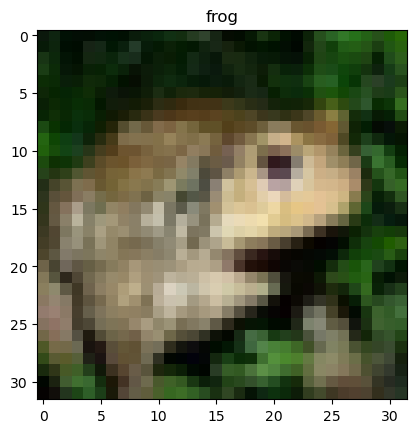

In [10]:
img,label=train_data[random.randint(1,50000)]
plt.imshow(img.permute(1,2,0))
plt.title(train_data.classes[label])
plt.show()

In [11]:
batch_size=32
train_dataloader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size)

In [12]:
train_dataloader

In [13]:
len(train_dataloader),len(test_dataloader)

(1563, 313)

In [14]:
train_dataloader.batch_size

32

In [15]:
next(iter(train_dataloader))

[tensor([[[[0.2902, 0.2471, 0.2471,  ..., 0.1451, 0.1569, 0.1412],
           [0.2706, 0.2235, 0.2118,  ..., 0.1373, 0.1137, 0.0902],
           [0.2745, 0.2471, 0.2157,  ..., 0.0784, 0.0941, 0.1255],
           ...,
           [0.4078, 0.4275, 0.4392,  ..., 0.2863, 0.2706, 0.2353],
           [0.3922, 0.4314, 0.4275,  ..., 0.3255, 0.2941, 0.2627],
           [0.3922, 0.4157, 0.3882,  ..., 0.2824, 0.2667, 0.2667]],
 
          [[0.3529, 0.3255, 0.3176,  ..., 0.1686, 0.1804, 0.1686],
           [0.3333, 0.3020, 0.2980,  ..., 0.1647, 0.1529, 0.1255],
           [0.3176, 0.3059, 0.3020,  ..., 0.1216, 0.1569, 0.1922],
           ...,
           [0.4039, 0.4235, 0.4392,  ..., 0.3686, 0.3647, 0.3412],
           [0.3882, 0.4275, 0.4275,  ..., 0.3843, 0.3686, 0.3529],
           [0.3882, 0.4118, 0.3882,  ..., 0.3765, 0.3608, 0.3647]],
 
          [[0.1216, 0.1020, 0.1216,  ..., 0.0667, 0.0706, 0.0510],
           [0.1255, 0.0863, 0.0824,  ..., 0.0431, 0.0314, 0.0275],
           [0.1373, 0.12

In [16]:
len(next(iter(train_dataloader)))

2

In [17]:
next(iter(train_dataloader))[0].shape    # 1 batch 32 images

torch.Size([32, 3, 32, 32])

In [18]:
next(iter(train_dataloader))[1].shape    # 32 labels

torch.Size([32])

In [19]:
class CIFAR10_VER1(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [20]:
32*32

1024

In [21]:
model_1=CIFAR10_VER1(1024,10,len(test_data.classes)).to("mps")

In [22]:
model_1

CIFAR10_VER1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [23]:
next(model_1.parameters()).device

device(type='mps', index=0)

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                            lr=0.1)

In [25]:
def train_step(model,data_loader,loss_fn,optimizer,accuracy_fn,device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss
        train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader,model,loss_fn,accuracy_fn,device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_score,
        device="mps"
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_score
    )

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device="mps")

  0%|          | 0/3 [00:00<?, ?it/s]